In [70]:
from ppget.source import ModelSource

start_date = "2007-07-01"
end_date = "2007-08-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [71]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.6812
2007-07-01 00:10:00    2.6502
2007-07-01 00:20:00    2.6266
2007-07-01 00:30:00    2.5242
2007-07-01 00:40:00    2.6000
Freq: 10T, Name: Global_active_power, dtype: float64

In [72]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 48
MODEL_NAME = "model/baseline/"

builder = DatasetBuilder(series, data_split=TrainSplit(train=0.9), window_size=WINDOW, normalised=False)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["validation"]["X"].shape, S["validation"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((3974, 48, 1), (3974,), (0, 48, 1), (0,), (442, 48, 1), (442,))

In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def predict(X):
  result = [0]
  for i in range(len(X)):
      if i == 0.0:
          continue
      else:
          result.append(X[i - 1])
  return result

def RMSE(expected, predicted):
    return sqrt(mean_squared_error(expected, predicted))

def validate_model(model, cost, expected, validation):
    p = model(validation)
    return cost(expected, p), p

In [74]:
%%time
error, predictions = validate_model(model=predict,
                                    cost=RMSE,
                                    expected=S["test"]["y"],
                                    validation=S["test"]["y"])

print(f"Baseline RMSE: {error}")

Baseline RMSE: 0.3171622912714008
CPU times: user 1.51 ms, sys: 239 µs, total: 1.75 ms
Wall time: 1.59 ms


In [75]:
len(predictions)

442

In [76]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results

,Predictions,Ground Truth
0,0.0000,1.2666
1,1.2666,0.4182
2,0.4182,0.1020
3,0.1020,0.1808
4,0.1808,0.2674
...,...,...
437,0.3814,0.2134
438,0.2134,0.1364
439,0.1364,0.1986
440,0.1986,0.2518


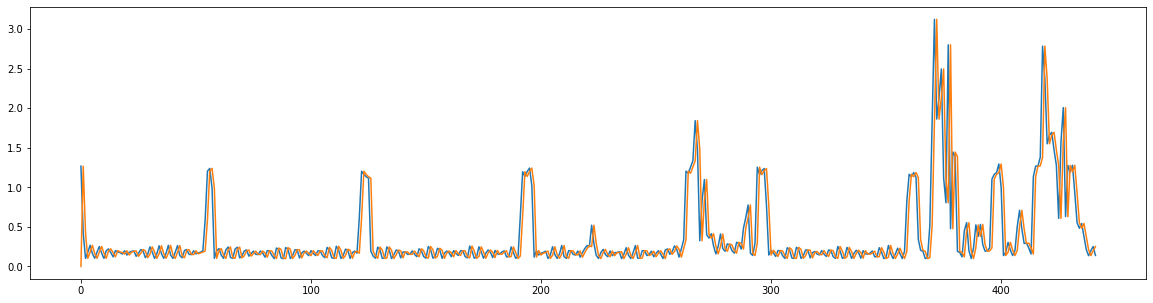

In [77]:
import matplotlib.pyplot as plt
import matplotlib as mplt
mplt.rcParams["figure.figsize"] = (20,5)

# plt.xlim([100, 200])
plt.plot(test_results["Ground Truth"])
plt.plot(test_results["Predictions"])
plt.show()